In [ ]:
import os
import urllib3
import requests
import pandas as pd
import time
from tqdm.auto import tqdm
from datetime import datetime, timedelta, date
from glob import glob
import rasterio
from pyidw import idw 
import geopandas as gpd #
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
import shutil
import warnings
import json
from glob import glob

warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 기상데이터 좌표

In [ ]:
future_loc=pd.read_csv("..data/future_loc.csv",encoding='cp949') # 현재, 미래 데이터 크롤링 
past_loc=pd.read_csv("..data/aws_loc_list.csv")  # 과거 데이터 크롤링 

# 크롤링

In [ ]:
def future_weather_crawling(date,times,locn):
    url = 'https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtFcst'
    
    params ={'serviceKey' : '3imQf/ygL+vTqRcXZ19hAwVhJhVDxZ2yRGtaRQPk/F3rFSVB2Kvu7LFfoGVhB4rYfTVk2kILGAhhJvmu9kQUzA==', #AuthenticationKey
             'pageNo' : '1',
             'numOfRows' : '1000',
             'dataType' : 'JSON', 
             'base_date' : date, 
             'base_time' : times, 
             'nx' : locn[1], 
             'ny' : locn[0], 
            }
    for i in range(5):  # 최대 5번까지 시도
        try:
            response = requests.get(url, params=params,verify=False)
            try:
                json_obj = json.loads(response.content)
                try:
                    json_obj=json_obj["response"]["body"]["items"]["item"]       
                    return json_obj
                except:
                    print("Retry1")
                    print(json_obj)
                    time.sleep(5)
            except:
                print(response.content)
                try:
                    json_obj = json.loads(response.content)
                    print(response,json_obj)
                    print("Retry2")
                    time.sleep(5)
                except json.JSONDecodeError:
                    time.sleep(2)
                    continue  
        except (requests.exceptions.HTTPError, requests.exceptions.ConnectionError) as e:
            print(f'Network ERROR')
            time.sleep(2)
    return np.nan 

In [ ]:
def past_weather_crawling(date,locn):
    
    url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'
    startDt=datetime.strptime(date[:8], '%Y%m%d') # 시작날짜
    startHh = datetime.strptime(date[8:], '%H')   # 시작시간
    endHh = (startHh + timedelta(hours=1))        # 시작날짜 + 1 (23같은경우 00이 되게 하기위해서 timedelta 이용)
    
    if(endHh.strftime('%H:%M:%S').split(':')[0]=='00'):
        endDt=(startDt + timedelta(days=1))
        
    else:
        endDt=startDt # endhh==00이면 시작날짜와 종료날짜가 달라야함. 22일 23시와 23일 00시 이런식.

    startDt=startDt.strftime('%Y%m%d')
    startHh=startHh.strftime('%H:%M:%S').split(':')[0]
    endDt=endDt.strftime('%Y%m%d')
    endHh=endHh.strftime('%H:%M:%S').split(':')[0]
    
    params ={'serviceKey' : '3imQf/ygL+vTqRcXZ19hAwVhJhVDxZ2yRGtaRQPk/F3rFSVB2Kvu7LFfoGVhB4rYfTVk2kILGAhhJvmu9kQUzA==', #AuthenticationKey
             'pageNo' : '1',
             'numOfRows' : '10',
             'dataType' : 'JSON', 
             'dataCd' : 'ASOS', 
             'dateCd' : 'HR', 
             'startDt' : startDt, #startdate
             'startHh' : startHh, #starttime
             'endDt' : endDt, # end date
             'endHh' : endHh, # end time
             'stnIds' : locn 
            }
    for i in range(5):  # 최대 5번까지 시도
        try:
            response = requests.get(url, params=params,verify=False)
            try:
                json_obj = json.loads(response.content)
                try:
                    json_obj=json_obj["response"]["body"]["items"]["item"][0]
                    times=json_obj['tm']
                    humidity=json_obj['hm']
                    windspeed=json_obj['ws']
                    winddir=json_obj['wd']
                    rain=json_obj['rn']
                    temp=json_obj['ta']              
                    return times, humidity, windspeed, winddir, rain, temp
                except:
                    print("Retry1")
                    print(json_obj)
                    time.sleep(5)
            except:
                print(response.content)
                try:
                    json_obj = json.loads(response.content)
                    print(response,json_obj)
                    print("Retry2")
                    time.sleep(5)
                except json.JSONDecodeError:
                    time.sleep(2)
                    continue   
        except (requests.exceptions.HTTPError, requests.exceptions.ConnectionError) as e:
            print(f'오류 발생 재시도')
            time.sleep(2)
    return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan  

In [ ]:
def iffuture(date,times,loc_list):
    result_list=[]
    
    fulldate=date+times
    file_name = datetime.strptime(fulldate, "%Y%m%d%H%M")
    file_1 = (file_name + timedelta(hours=1, minutes=30)).strftime("%Y%m%d%H%M")
    file_2 = (file_name + timedelta(hours=2, minutes=30)).strftime("%Y%m%d%H%M")
    file_3 = (file_name + timedelta(hours=3, minutes=30)).strftime("%Y%m%d%H%M")
    
    for i in tqdm(range(len(loc_list))):
        loc=(loc_list['격자 Y'].iloc[i],loc_list['격자 X'].iloc[i])

        result=pd.DataFrame(future_weather_crawling(date,times,loc))

        t_1=file_1[-4:]
        t_2=file_2[-4:]
        t_3=file_3[-4:]

        time_list = [t_1,t_2,t_3]

        output = result[result['fcstTime'].isin(time_list)]
        output = output.pivot(index=['baseDate', 'baseTime', 'fcstDate', 'fcstTime', 'nx', 'ny'], columns='category', values='fcstValue').reset_index()

        output.drop(['LGT','VEC','SKY','UUU','VVV','PTY'],axis=1,inplace=True)
        output.columns=['baseDate', 'baseTime', 'fcstDate', 'fcstTime', 'nx', 'ny','습도','강수량','기온','풍속']
        result_list.append(output)

    test = pd.concat(result_list, ignore_index=True)

    tmp1=test[test['fcstTime']==t_1].reset_index(drop=True)
    tmp2=test[test['fcstTime']==t_2].reset_index(drop=True)
    tmp3=test[test['fcstTime']==t_3].reset_index(drop=True)

    tmp1.to_csv(f'{f_path}/{file_1}.csv',index=False,encoding='cp949')
    tmp2.to_csv(f'{f_path}/{file_2}.csv',index=False,encoding='cp949')
    tmp3.to_csv(f'{f_path}/{file_3}.csv',index=False,encoding='cp949')
    
    return [file_1,file_2,file_3]
    
def ifpast(date,times,loc_list):
    fulldate=date+times
    
    loc_num=loc_list['지점번호']
    file=fulldate+'00'

    tmp=pd.DataFrame(columns=['location information', 'longitude','latitude','time','humidity','wind speed','wind direction','precipitation','temperature'])
    for j in tqdm(range(len(loc_num))):
        result=[loc_num[j],loc_list['lon'][j],loc_list['lat'][j]]
        result.extend(past_weather_crawling(fulldate,loc_num[j])) 
        tmp = pd.concat([tmp, pd.DataFrame([result], columns=tmp.columns)], ignore_index=True)
    tmp.to_csv(f"{f_path}/{file}.csv",index=False,encoding='cp949')
    
    return [file]

In [ ]:
def interpolation(filenames,tense):
    for i in range(len(filenames)):
        image_list=[]
        os.makedirs(f"database/{filenames[i]}/interpolation", exist_ok=True)
        data=pd.read_csv(f'{f_path}/{filenames[i]}.csv',encoding='cp949')
        
        if(tense==1):
            data.drop(['baseDate','baseTime','fcstDate','fcstTime'],axis=1,inplace=True)
            data.columns=['nx','ny','humidity','rainfall','temp','wind_sp']
            data['rainfall'] = data['rainfall'].replace('강수없음', '0mm')
            data['rainfall']=[j[:-2] for j in data['rainfall']]
            data['rainfall']=data['rainfall'].fillna(0)
            data['rainfall']=data['rainfall'].astype('float')
            data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.ny, data.nx)).drop(['nx','ny'],axis=1)
        else:
            data.columns=['loc_info', 'longitude', 'latitude', 'time','humidity', 'wind_sp', 'wind_dr', 'rainfall','temp']
            data.dropna(subset=['time'], inplace=True)
            data['rainfall']=data['rainfall'].fillna(0)
            data=data.dropna()
            data.drop(['loc_info','time'],axis=1,inplace=True)
            data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
            
        data.to_file(f'tmp.shp')

        for j in range(len(features)):
            idw.idw_interpolation(
                input_point_shapefile=f'tmp.shp', # 보간하고자 하는 shp 파일 
                extent_shapefile="boundary/boundary.shp", # 경계 shp 파일(현재 강원도)
                column_name=features[j], # 보간하고자 하는 feature 이름. 
                power=2, # 거리 가중치 계수 
                search_radious=8, # 검색하고자 하는 범위 
                output_resolution=400, # 결과물 해상도 
            )
            image=rasterio.open(f'tmp_idw.tif')
            image=pd.DataFrame(image.read(1))
            image_list.append(image)
            shutil.move(f'tmp_idw.tif', f"{f_path}{filenames[i]}/interpolation/{filenames[i]}_{features[j]}.tif")
            
        temps,hums,rains,winds=[],[],[],[]
        for j in range(len(image.index)):
            for k in range(len(image.columns)):
                hums.append(image_list[0].iloc[j][k])
                rains.append(image_list[1].iloc[j][k])
                temps.append(image_list[2].iloc[j][k])
                winds.append(image_list[3].iloc[j][k])
                
        climates = {'temp': temps, 'hum': hums, 'rain': rains, 'wind': winds}
        df = pd.DataFrame(climates)
        df=df.replace(32767.0,-9999)
        #df.to_csv(f"{f_path}/{date}{file[epoch]}_idw.csv",index=False)
        x_train=[]
        for j in tqdm(range(len(df))):
            x_train.append(np.array(df.loc[j, ['temp','hum','rain','wind']]).astype(float))
        climate = np.array(x_train)
        np.save(f'{f_path}{filenames[i]}/{filenames[i]}.npy', climate)
        os.remove(f'{f_path}/{filenames[i]}.csv')
        #os.remove(f'{f_path}/{date}{file[epoch]}.csv')
    os.remove(f"tmp.shp")
    os.remove(f"tmp.cpg")
    os.remove(f"tmp.dbf")
    os.remove(f"tmp.shx")
    #os.remove(f"tmp_idw.tif")
    

In [ ]:
def image_to_array(InputImage):
    Image = gdal.Open(InputImage, gdal.GA_Update)
    array = Image.ReadAsArray()
    print(array.shape)
    return array

def array_to_image(InputArr, OutputImage, RefImage):
    Image = gdal.Open(RefImage, gdal.GA_Update)
    ImageArr = Image.ReadAsArray()
    
    open(OutputImage, 'w')
    Output = gdal.GetDriverByName('GTiff').Create(OutputImage, ImageArr.shape[1], ImageArr.shape[0], 1, gdal.GDT_Float32)
    #writting output raster
    Output.GetRasterBand(1).WriteArray(InputArr)
    Output.SetProjection(Image.GetProjection())
    Output.SetGeoTransform(Image.GetGeoTransform())

    Image = None
    Output = None

In [ ]:
f_path = f'database/'
os.makedirs(f"{f_path}", exist_ok=True)
today = date.today()
features=['humidity','wind_sp','rainfall','temp']

inputdate=input("yyyymmdd 형식으로 적어주세요 ")
dates= datetime.strptime(inputdate, "%Y%m%d").date()

if(dates>=today):
    print("미래")
    tense=1
    times=input("tt30 형식으로 적어주세요")
    filenames=iffuture(inputdate,times,future_loc)
    
else:
    print("과거")
    tense=0
    times=input("tt형식으로 적어주세요.")
    filenames=ifpast(inputdate,times,past_loc)
 
# 보간법 

interpolation(filenames,tense)

# 보간 및 input형식 만들기

In [1]:
import tensorflow as tf
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

model = tf.keras.models.load_model("C:/Users/user/fire_model/cnn24")

In [2]:
from glob import glob
import os
os.listdir('../data/database/')

['메모장.txt',
 '202305291500',
 '202305091600',
 '202305021000',
 '202305111600',
 '202305131800',
 '202303181600',
 '202303211400',
 '202203041200']

In [3]:
inputdate='202203041200'
climate_test=np.load(f'../data/database/{inputdate}/{inputdate}.npy')

In [4]:
Height_test=np.load('../data/modeling_data/test/Height_test.npy')
NDVI_test=np.load('../data/modeling_data/test/NDVI_test.npy')
Slope_test=np.load('../data/modeling_data/test/Slope_test.npy')
landuse_test=np.load('../data/modeling_data/test/Landuse_test.npy')
popden_test=np.load('../data/modeling_data/test/population_density_test.npy')

In [5]:
x_test = {
    'height_input': Height_test,
    'ndvi_input': NDVI_test,
    'slope_input': Slope_test,
    'landuse_input': landuse_test,
    'popden_input': popden_test,
    'climate_input':climate_test
}

In [6]:
y_pred = model.predict(x_test)
#y_pred2 = model2.predict(x_test2)

3475/3475 [==============================] - 42s 12ms/step


In [7]:
result_arr = np.zeros((278, 400))
x = 0
for i in range(278):
    for j in range(400):
        result_arr[i, j] = y_pred[x]  # 결과 배열에 값 추가
        x += 1
        
# result_arr2 = np.zeros((278, 400))
# x = 0
# for i in range(278):
#     for j in range(400):
#         result_arr2[i, j] = y_pred2[x]  # 결과 배열에 값 추가
#         x += 1

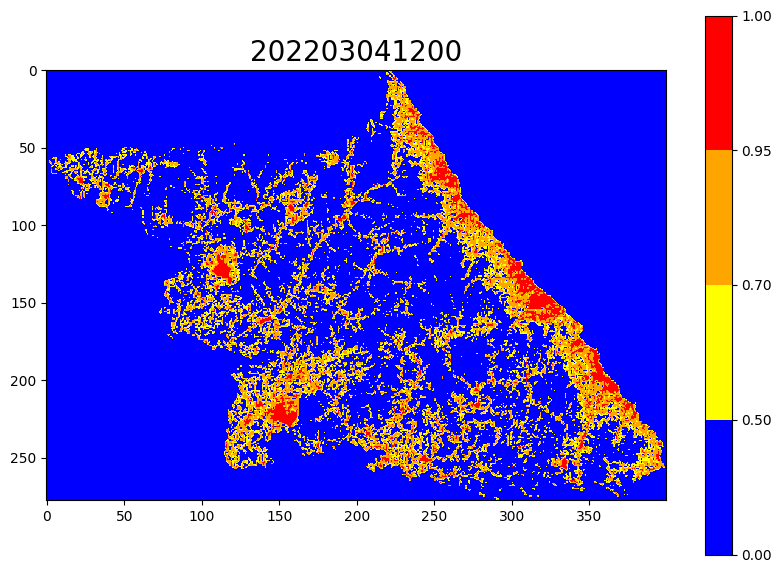

In [8]:
import matplotlib.pyplot as plt
cmaps = plt.cm.colors.ListedColormap(['blue', 'yellow','orange', 'red'])  # 파란색, 노란색, 빨간색 순서로 리스트 생성
bounds = [0, 0.5, 0.7, 0.95, 1]  # 범위 설정
norm = plt.cm.colors.BoundaryNorm(bounds, cmaps.N)  # 범위와 컬러맵의 개수를 사용하여 정규화 객체 생성
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7))
plt.title(f"{inputdate}", fontsize=20)
plt.imshow(result_arr, cmap=cmaps, norm=norm)
plt.colorbar()
plt.show()
#fig.savefig(f"image/상관계수히트맵", transparent = True,dpi=300, bbox_inches='tight');

In [ ]:
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(10,7))
plt.title(f"{inputdate}", fontsize=20)
plt.imshow(result_arr, cmap='hot_r', vmin=0,vmax=1)
plt.colorbar()
plt.show()
#fig.savefig(f"image/상관계수히트맵", transparent = True,dpi=300, bbox_inches='tight');

In [ ]:
np.save(f'database/{inputdate}/{inputdate}cnn4_only_climate_result.npy', result_arr)

# 밑으로는 돌리지말자"

In [ ]:
break

In [ ]:
prev_cnn24=np.load(f'database/{inputdate}/{inputdate}_prev_cnn24.npy')
new_cnn24=np.load(f'database/{inputdate}/{inputdate}_new_cnn24.npy')

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7))
plt.title(f"prev_{inputdate}", fontsize=20)
plt.imshow(prev_cnn24, cmap=cmaps, norm=norm)
plt.colorbar()
plt.show()
#fig.savefig(f"image/상관계수히트맵", transparent = True,dpi=300, bbox_inches='tight');

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7))
plt.title(f"new{inputdate}", fontsize=20)
plt.imshow(new_cnn24, cmap=cmaps, norm=norm)
plt.colorbar()
plt.show()
#fig.savefig(f"image/상관계수히트맵", transparent = True,dpi=300, bbox_inches='tight');

In [ ]:
import os
np.save(f'database/{inputdate}/{inputdate}_result.npy', result_arr)
os.remove(f'database/{inputdate}/{inputdate}.npy')

In [ ]:
InputArr=result_arr
OutputImage=f'database/{inputdate}/{inputdate}_.tif'
RefImage='boundary/boundary_blank_resized.tif'
array_to_image(InputArr, OutputImage, RefImage)

In [ ]:
InputArr=test
OutputImage=f'database/202203041200/202203041200_.tif'
RefImage='boundary/boundary_blank_resized.tif'
array_to_image(InputArr, OutputImage, RefImage)

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7))
#plt.title(f"{inputdate}", fontsize=20)
plt.imshow(test, cmap='hot',vmax=1,vmin=0)
plt.colorbar()
plt.show()
#fig.savefig(f"image/상관계수히트맵", transparent = True,dpi=300, bbox_inches='tight');